# import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import optuna

C:\Users\Gbanjubola\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read train and test data

In [3]:
data = pd.read_json('train.json')
test =  pd.read_json('test.json')
data

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


# Data Analysis

In [4]:
data.drop('id', axis = 1, inplace = True)

In [5]:
test_id = test.id
print(test.columns)

Index(['id', 'ingredients'], dtype='object')


In [6]:
test.drop('id', axis = 1, inplace = True)

In [7]:
data

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...
39769,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,chinese,"[boneless chicken skinless thigh, minced garli..."


<Axes: xlabel='count', ylabel='cuisine'>

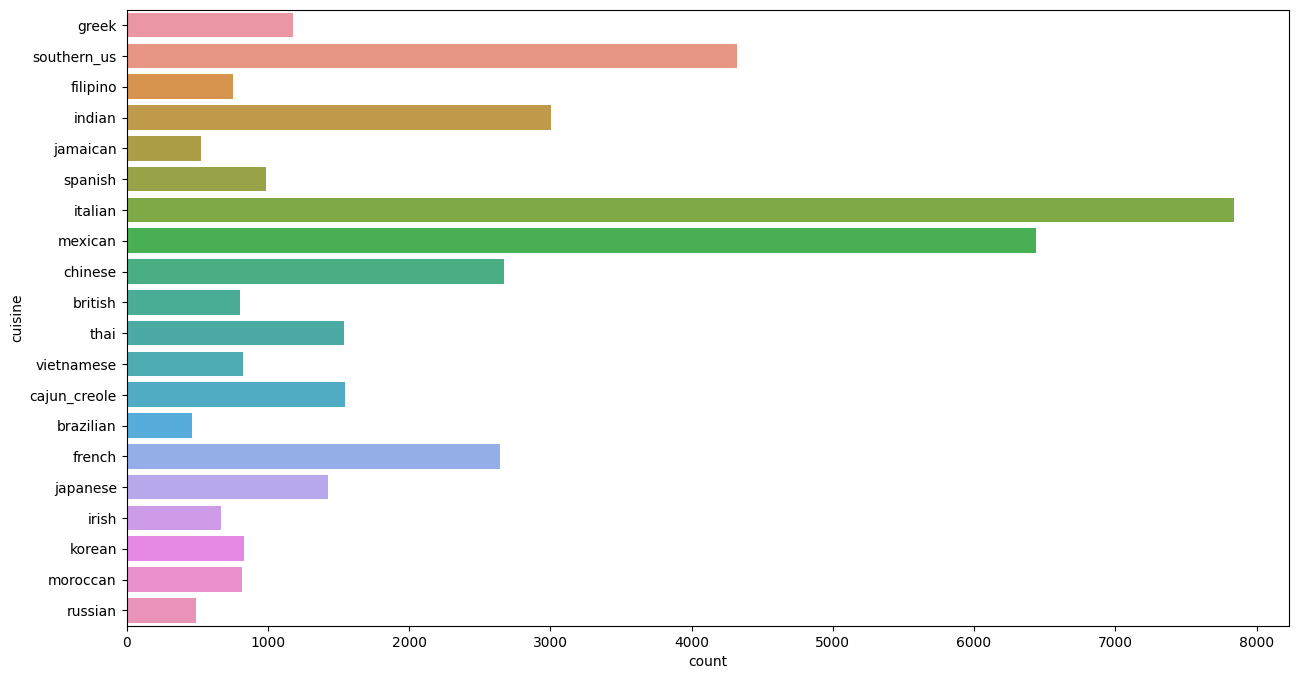

In [13]:
plt.figure(figsize=(15, 8))
sn.countplot(data = data, y = 'cuisine')

In [8]:
test.head(20)

,ingredients
0,"[baking powder, eggs, all-purpose flour, raisi..."
1,"[sugar, egg yolks, corn starch, cream of tarta..."
2,"[sausage links, fennel bulb, fronds, olive oil..."
3,"[meat cuts, file powder, smoked sausage, okra,..."
4,"[ground black pepper, salt, sausage casings, l..."
5,"[baking powder, all-purpose flour, peach slice..."
6,"[grape juice, orange, white zinfandel]"
7,"[ground ginger, white pepper, green onions, or..."
8,"[diced onions, taco seasoning mix, all-purpose..."
9,"[eggs, cherries, dates, dark muscovado sugar, ..."


In [14]:
data.cuisine.value_counts()

cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: count, dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cuisine      39774 non-null  object
 1   ingredients  39774 non-null  object
dtypes: object(2)
memory usage: 621.6+ KB


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ingredients  9944 non-null   object
dtypes: object(1)
memory usage: 77.8+ KB


data.describe()

# Data Preprocessing

## text cleaning

In [18]:
# convertion of the ingredients text from lists to strings
data['ingredients'] = data['ingredients'].apply(', '.join)

In [19]:
test['ingredients'] = test['ingredients'].apply(', '.join)

In [20]:
# convertion of all string characters to lower case
data.ingredients = data.ingredients.str.lower()

In [21]:
test.ingredients = data.ingredients.str.lower()

In [22]:
data

,cuisine,ingredients
0,greek,"romaine lettuce, black olives, grape tomatoes,..."
1,southern_us,"plain flour, ground pepper, salt, tomatoes, gr..."
2,filipino,"eggs, pepper, salt, mayonaise, cooking oil, gr..."
3,indian,"water, vegetable oil, wheat, salt"
4,indian,"black pepper, shallots, cornflour, cayenne pep..."
...,...,...
39769,irish,"light brown sugar, granulated sugar, butter, w..."
39770,italian,"kraft zesty italian dressing, purple onion, br..."
39771,irish,"eggs, citrus fruit, raisins, sourdough starter..."
39772,chinese,"boneless chicken skinless thigh, minced garlic..."


In [23]:
test

,ingredients
0,"romaine lettuce, black olives, grape tomatoes,..."
1,"plain flour, ground pepper, salt, tomatoes, gr..."
2,"eggs, pepper, salt, mayonaise, cooking oil, gr..."
3,"water, vegetable oil, wheat, salt"
4,"black pepper, shallots, cornflour, cayenne pep..."
...,...
9939,"daisy sour cream, cooked ham, chili powder, pi..."
9940,"dry white wine, fresh parsley, minced garlic, ..."
9941,"milk, vanilla, sugar, large egg yolks"
9942,"olive oil, tomato juice, garlic, fresh lemon j..."


# use vectorizers
The TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer is a common technique used to convert text data into a numerical format that can be used for machine learning tasks. It is particularly useful for text classification, information retrieval, and natural language processing applications. TF-IDF vectorization assigns numerical values to words based on their importance within a document or a collection of documents.

Here's what TF-IDF does and how it can transform your data:

Term Frequency (TF)
Inverse Document Frequency (IDF)
TF-IDF Score


help(TfidfVectorizer)

In [24]:
# use this to encode individual items in the ingredients
tfidf = TfidfVectorizer()
combined_data = pd.concat([data.ingredients, test.ingredients], axis = 0)
combined_data

0       romaine lettuce, black olives, grape tomatoes,...
1       plain flour, ground pepper, salt, tomatoes, gr...
2       eggs, pepper, salt, mayonaise, cooking oil, gr...
3                       water, vegetable oil, wheat, salt
4       black pepper, shallots, cornflour, cayenne pep...
                              ...                        
9939    daisy sour cream, cooked ham, chili powder, pi...
9940    dry white wine, fresh parsley, minced garlic, ...
9941                milk, vanilla, sugar, large egg yolks
9942    olive oil, tomato juice, garlic, fresh lemon j...
9943    water, coconut sugar, frozen strawberries, sim...
Name: ingredients, Length: 49718, dtype: object

In [25]:
tfidf.fit(combined_data)

TfidfVectorizer()

In [26]:
ingredients_tfidf = tfidf.transform(data['ingredients'])
ingredients_tfidf

<39774x3010 sparse matrix of type '<class 'numpy.float64'>'
	with 761951 stored elements in Compressed Sparse Row format>

In [27]:
test_tfidf = tfidf.transform(test['ingredients'])
test_tfidf

<9944x3010 sparse matrix of type '<class 'numpy.float64'>'
	with 190137 stored elements in Compressed Sparse Row format>

# Data splitting

In [28]:
X_train, X_test, y_train, y_test = train_test_split(ingredients_tfidf, data['cuisine'], test_size=0.2, random_state=42)

In [29]:
X_train

<31819x3010 sparse matrix of type '<class 'numpy.float64'>'
	with 609586 stored elements in Compressed Sparse Row format>

In [30]:
y_train

23436        mexican
7901          indian
25718       filipino
16909       moroccan
34830        mexican
            ...     
6265         mexican
11284        italian
38158        chinese
860      southern_us
15795         french
Name: cuisine, Length: 31819, dtype: object

# Model building

In [31]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [32]:
predictions = lr_model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, predictions))

Accuracy:  0.7810182275298554


In [34]:
lr_cv_model = LogisticRegressionCV(max_iter=6000)
lr_cv_model.fit(X_train, y_train)

LogisticRegressionCV(max_iter=6000)

In [35]:
predictions = lr_cv_model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, predictions))

Accuracy:  0.7880578252671276


In [36]:
cat_model = CatBoostClassifier()
cat_model.fit(X_train, y_train)

Learning rate set to 0.094397
0:	learn: 2.6797928	total: 12.4s	remaining: 3h 26m 34s
1:	learn: 2.5141405	total: 24.4s	remaining: 3h 23m 2s
2:	learn: 2.4014790	total: 36.3s	remaining: 3h 20m 55s
3:	learn: 2.3036086	total: 47.8s	remaining: 3h 18m 19s
4:	learn: 2.2302779	total: 59.1s	remaining: 3h 15m 58s
5:	learn: 2.1594286	total: 1m 11s	remaining: 3h 18m 12s
6:	learn: 2.1129299	total: 1m 23s	remaining: 3h 17m 33s
7:	learn: 2.0680676	total: 1m 35s	remaining: 3h 18m 21s
8:	learn: 2.0210033	total: 1m 47s	remaining: 3h 17m 16s
9:	learn: 1.9852589	total: 1m 59s	remaining: 3h 16m 57s
10:	learn: 1.9510859	total: 2m 11s	remaining: 3h 16m 56s
11:	learn: 1.9215222	total: 2m 23s	remaining: 3h 16m 24s
12:	learn: 1.8954797	total: 2m 34s	remaining: 3h 15m 23s
13:	learn: 1.8615356	total: 2m 46s	remaining: 3h 15m 11s
14:	learn: 1.8391791	total: 2m 57s	remaining: 3h 14m 16s
15:	learn: 1.8218805	total: 3m 8s	remaining: 3h 13m 37s
16:	learn: 1.8028603	total: 3m 21s	remaining: 3h 13m 52s
17:	learn: 1.78335

144:	learn: 1.1405154	total: 28m	remaining: 2h 45m 6s
145:	learn: 1.1368802	total: 28m 11s	remaining: 2h 44m 53s
146:	learn: 1.1357549	total: 28m 23s	remaining: 2h 44m 43s
147:	learn: 1.1331862	total: 28m 34s	remaining: 2h 44m 30s
148:	learn: 1.1317839	total: 28m 45s	remaining: 2h 44m 16s
149:	learn: 1.1306011	total: 28m 57s	remaining: 2h 44m 7s
150:	learn: 1.1286557	total: 29m 9s	remaining: 2h 43m 53s
151:	learn: 1.1266359	total: 29m 20s	remaining: 2h 43m 42s
152:	learn: 1.1244476	total: 29m 32s	remaining: 2h 43m 30s
153:	learn: 1.1232350	total: 29m 45s	remaining: 2h 43m 27s
154:	learn: 1.1211978	total: 29m 57s	remaining: 2h 43m 19s
155:	learn: 1.1184989	total: 30m 8s	remaining: 2h 43m 5s
156:	learn: 1.1157039	total: 30m 20s	remaining: 2h 42m 56s
157:	learn: 1.1142439	total: 30m 31s	remaining: 2h 42m 42s
158:	learn: 1.1119526	total: 30m 43s	remaining: 2h 42m 33s
159:	learn: 1.1111129	total: 30m 55s	remaining: 2h 42m 20s
160:	learn: 1.1084865	total: 31m 6s	remaining: 2h 42m 7s
161:	lea

284:	learn: 0.9573183	total: 55m 5s	remaining: 2h 18m 12s
285:	learn: 0.9569645	total: 55m 17s	remaining: 2h 18m 1s
286:	learn: 0.9561844	total: 55m 28s	remaining: 2h 17m 49s
287:	learn: 0.9548077	total: 55m 40s	remaining: 2h 17m 37s
288:	learn: 0.9533740	total: 55m 52s	remaining: 2h 17m 26s
289:	learn: 0.9527821	total: 56m 3s	remaining: 2h 17m 14s
290:	learn: 0.9523781	total: 56m 16s	remaining: 2h 17m 7s
291:	learn: 0.9514011	total: 56m 28s	remaining: 2h 16m 56s
292:	learn: 0.9509204	total: 56m 40s	remaining: 2h 16m 45s
293:	learn: 0.9503985	total: 56m 51s	remaining: 2h 16m 33s
294:	learn: 0.9490051	total: 57m 3s	remaining: 2h 16m 22s
295:	learn: 0.9480012	total: 57m 15s	remaining: 2h 16m 11s
296:	learn: 0.9476854	total: 57m 26s	remaining: 2h 15m 58s
297:	learn: 0.9466829	total: 57m 38s	remaining: 2h 15m 47s
298:	learn: 0.9457605	total: 57m 49s	remaining: 2h 15m 35s
299:	learn: 0.9443195	total: 58m 1s	remaining: 2h 15m 22s
300:	learn: 0.9439867	total: 58m 13s	remaining: 2h 15m 12s
301

421:	learn: 0.8738910	total: 1h 21m 17s	remaining: 1h 51m 20s
422:	learn: 0.8733031	total: 1h 21m 28s	remaining: 1h 51m 8s
423:	learn: 0.8730829	total: 1h 21m 40s	remaining: 1h 50m 57s
424:	learn: 0.8723814	total: 1h 21m 52s	remaining: 1h 50m 46s
425:	learn: 0.8720477	total: 1h 22m 4s	remaining: 1h 50m 34s
426:	learn: 0.8715449	total: 1h 22m 15s	remaining: 1h 50m 22s
427:	learn: 0.8712155	total: 1h 22m 26s	remaining: 1h 50m 11s
428:	learn: 0.8708266	total: 1h 22m 38s	remaining: 1h 50m
429:	learn: 0.8705005	total: 1h 22m 50s	remaining: 1h 49m 48s
430:	learn: 0.8700787	total: 1h 23m 1s	remaining: 1h 49m 36s
431:	learn: 0.8697043	total: 1h 23m 13s	remaining: 1h 49m 25s
432:	learn: 0.8694837	total: 1h 23m 24s	remaining: 1h 49m 13s
433:	learn: 0.8691179	total: 1h 23m 36s	remaining: 1h 49m 2s
434:	learn: 0.8688697	total: 1h 23m 47s	remaining: 1h 48m 50s
435:	learn: 0.8687962	total: 1h 23m 59s	remaining: 1h 48m 38s
436:	learn: 0.8683768	total: 1h 24m 11s	remaining: 1h 48m 27s
437:	learn: 0.86

555:	learn: 0.8266149	total: 1h 46m 51s	remaining: 1h 25m 20s
556:	learn: 0.8263126	total: 1h 47m 3s	remaining: 1h 25m 8s
557:	learn: 0.8262600	total: 1h 47m 14s	remaining: 1h 24m 56s
558:	learn: 0.8261067	total: 1h 47m 25s	remaining: 1h 24m 45s
559:	learn: 0.8259900	total: 1h 47m 37s	remaining: 1h 24m 33s
560:	learn: 0.8256569	total: 1h 47m 48s	remaining: 1h 24m 22s
561:	learn: 0.8253777	total: 1h 47m 59s	remaining: 1h 24m 10s
562:	learn: 0.8252547	total: 1h 48m 11s	remaining: 1h 23m 58s
563:	learn: 0.8248463	total: 1h 48m 22s	remaining: 1h 23m 47s
564:	learn: 0.8245727	total: 1h 48m 33s	remaining: 1h 23m 35s
565:	learn: 0.8242663	total: 1h 48m 45s	remaining: 1h 23m 23s
566:	learn: 0.8239589	total: 1h 48m 56s	remaining: 1h 23m 12s
567:	learn: 0.8239040	total: 1h 49m 8s	remaining: 1h 23m
568:	learn: 0.8237291	total: 1h 49m 19s	remaining: 1h 22m 48s
569:	learn: 0.8232560	total: 1h 49m 30s	remaining: 1h 22m 36s
570:	learn: 0.8229869	total: 1h 49m 42s	remaining: 1h 22m 25s
571:	learn: 0.8

691:	learn: 0.7947508	total: 2h 13m 27s	remaining: 59m 23s
692:	learn: 0.7943775	total: 2h 13m 39s	remaining: 59m 12s
693:	learn: 0.7942469	total: 2h 13m 50s	remaining: 59m 1s
694:	learn: 0.7942006	total: 2h 14m 2s	remaining: 58m 49s
695:	learn: 0.7939276	total: 2h 14m 14s	remaining: 58m 37s
696:	learn: 0.7938661	total: 2h 14m 25s	remaining: 58m 26s
697:	learn: 0.7936002	total: 2h 14m 37s	remaining: 58m 14s
698:	learn: 0.7931636	total: 2h 14m 49s	remaining: 58m 3s
699:	learn: 0.7931383	total: 2h 15m	remaining: 57m 51s
700:	learn: 0.7926936	total: 2h 15m 12s	remaining: 57m 40s
701:	learn: 0.7926033	total: 2h 15m 24s	remaining: 57m 28s
702:	learn: 0.7925428	total: 2h 15m 36s	remaining: 57m 17s
703:	learn: 0.7924648	total: 2h 15m 47s	remaining: 57m 5s
704:	learn: 0.7922892	total: 2h 15m 59s	remaining: 56m 54s
705:	learn: 0.7922548	total: 2h 16m 10s	remaining: 56m 42s
706:	learn: 0.7919192	total: 2h 16m 22s	remaining: 56m 31s
707:	learn: 0.7918785	total: 2h 16m 33s	remaining: 56m 19s
708:	

831:	learn: 0.7699066	total: 2h 40m 25s	remaining: 32m 23s
832:	learn: 0.7698020	total: 2h 40m 38s	remaining: 32m 12s
833:	learn: 0.7697404	total: 2h 40m 49s	remaining: 32m
834:	learn: 0.7693474	total: 2h 41m 1s	remaining: 31m 49s
835:	learn: 0.7693284	total: 2h 41m 12s	remaining: 31m 37s
836:	learn: 0.7691360	total: 2h 41m 24s	remaining: 31m 25s
837:	learn: 0.7691290	total: 2h 41m 35s	remaining: 31m 14s
838:	learn: 0.7690769	total: 2h 41m 47s	remaining: 31m 2s
839:	learn: 0.7690365	total: 2h 41m 59s	remaining: 30m 51s
840:	learn: 0.7688783	total: 2h 42m 10s	remaining: 30m 39s
841:	learn: 0.7688622	total: 2h 42m 21s	remaining: 30m 28s
842:	learn: 0.7687357	total: 2h 42m 33s	remaining: 30m 16s
843:	learn: 0.7686289	total: 2h 42m 45s	remaining: 30m 4s
844:	learn: 0.7685866	total: 2h 42m 57s	remaining: 29m 53s
845:	learn: 0.7685599	total: 2h 43m 8s	remaining: 29m 41s
846:	learn: 0.7682881	total: 2h 43m 19s	remaining: 29m 30s
847:	learn: 0.7682583	total: 2h 43m 32s	remaining: 29m 18s
848:	

973:	learn: 0.7523170	total: 3h 7m 55s	remaining: 5m
974:	learn: 0.7522776	total: 3h 8m 6s	remaining: 4m 49s
975:	learn: 0.7521309	total: 3h 8m 18s	remaining: 4m 37s
976:	learn: 0.7521014	total: 3h 8m 30s	remaining: 4m 26s
977:	learn: 0.7519844	total: 3h 8m 41s	remaining: 4m 14s
978:	learn: 0.7517664	total: 3h 8m 54s	remaining: 4m 3s
979:	learn: 0.7515803	total: 3h 9m 5s	remaining: 3m 51s
980:	learn: 0.7515448	total: 3h 9m 16s	remaining: 3m 39s
981:	learn: 0.7515036	total: 3h 9m 28s	remaining: 3m 28s
982:	learn: 0.7513990	total: 3h 9m 40s	remaining: 3m 16s
983:	learn: 0.7513681	total: 3h 9m 51s	remaining: 3m 5s
984:	learn: 0.7512198	total: 3h 10m 2s	remaining: 2m 53s
985:	learn: 0.7511127	total: 3h 10m 14s	remaining: 2m 42s
986:	learn: 0.7507166	total: 3h 10m 25s	remaining: 2m 30s
987:	learn: 0.7506344	total: 3h 10m 37s	remaining: 2m 18s
988:	learn: 0.7501659	total: 3h 10m 48s	remaining: 2m 7s
989:	learn: 0.7501574	total: 3h 11m	remaining: 1m 55s
990:	learn: 0.7501048	total: 3h 11m 11s

In [37]:
predictions = cat_model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, predictions))

Accuracy:  0.7635449402891263


In [41]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

In [42]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [43]:
predictions = xgb_model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test_encoded, predictions))

Accuracy:  0.7797611565053425


In [44]:
svc_model = SVC()
svc_model.fit(X_train, y_train)

SVC()

In [45]:
predictions = svc_model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, predictions))

Accuracy:  0.8001257071024512


In [46]:
test_predict = svc_model.predict(test_tfidf)

In [49]:
pd.read_csv('sample_submission.csv')

,id,cuisine
0,35203,italian
1,17600,italian
2,35200,italian
3,17602,italian
4,17605,italian
...,...,...
9939,46537,italian
9940,30854,italian
9941,15430,italian
9942,46530,italian


In [47]:
test_df = pd.DataFrame(test_predict, columns=['cuisine'])

In [48]:
test_df = pd.DataFrame(test_predict, columns=['cuisine'])
sub_df = pd.concat([test_id, test_df], axis = 1, ignore_index= True )
sub_df.columns = ['id', 'cuisine']
sub_df

,id,cuisine
0,18009,greek
1,28583,southern_us
2,41580,filipino
3,29752,indian
4,35687,indian
...,...,...
9939,30246,mexican
9940,36028,italian
9941,22339,french
9942,42525,indian


In [ ]:
sub_df.to_csv('submission_file.csv', index= False)

# using optuna for hyper parameter tuning
def objective(trial):
    C = trial.suggest_float('C', 1e-5, 1e5)
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])
    degree = trial.suggest_int('degree', 1, 5)
    
    clf = SVC(kernel=kernel, gamma="scale", random_state=0, C=C,degree=degree)
    
    svc_op_model = clf.fit(X_train, y_train)
    svc_op_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

In [50]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [51]:
predictions = rf_model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, predictions))

Accuracy:  0.7474544311753614
